# MintPy Processing

## setup

In [1]:
%matplotlib inline
import glob
import sys
import shutil
import os
import matplotlib.pyplot as plt
from mintpy.utils import readfile, writefile, utils as ut
from mintpy import workflow, view, tsview, plot_network, plot_transection, plot_coherence_matrix
from mintpy.unwrap_error_phase_closure import plot_num_triplet_with_nonzero_integer_ambiguity
from mintpy.tsview import timeseriesViewer

from mintpy.objects import timeseries
from datetime import datetime
import numpy as np
from skimage.morphology import remove_small_objects

from scipy.stats import linregress
import pandas as pd
import matplotlib
import datetime

['load_data', 'modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error']
  ['invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography']
  ['residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']

## load_data

In [2]:
cd /mnt/i/hyp3_downloads/asc_upper

/mnt/i/hyp3_downloads/asc_upper


In [3]:
cp ~/data/hyp3_insar/hyp3.cfg ./hyp3.cfg

In [4]:
!smallbaselineApp.py ./hyp3.cfg --dostep load_data

MintPy release version v1.3.0-128, release date 2021-09-27
--RUN-at-2021-10-26 15:14:18.584750--
Current directory: /mnt/i/hyp3_downloads/asc_upper
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: hyp3
Go to work directory: /mnt/i/hyp3_downloads/asc_upper
read custom template file: /mnt/i/hyp3_downloads/asc_upper/hyp3.cfg
update default template based on input custom template
    mintpy.load.unwFile: /mnt/i/hyp3_downloads/asc_upper/\*/\*unw_phase_clip.tif --> /mnt/i/hyp3_downloads/asc_upper/*/*unw_phase_clip.tif
    mintpy.load.corFile: /mnt/i/hyp3_downloads/asc_upper/\*/\*corr_clip.tif --> /mnt/i/hyp3_downloads/asc_uppe

## Set up Directory

In [4]:
mkdir ~/data/desc_lower

In [5]:
cd ~/data/desc_lower

/home/fw/data/desc_lower


In [6]:
cp ~/data/hyp3_insar/hyp3.cfg ./hyp3.cfg

In [7]:
cp -r /mnt/i/hyp3_downloads/desc_lower/inputs ~/data/desc_lower/inputs

## Generate Water Mask

input geometry file: ./inputs/geometryGeo.h5
read ./inputs/geometryGeo.h5 waterMask
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value < 0.5
create HDF5 file: waterMask.h5 with w mode
create dataset /mask of bool       in size of (700, 700)           with compression=None
finished writing to waterMask.h5
time used: 00 mins 0.1 secs.
view.py waterMask.h5 --noverbose


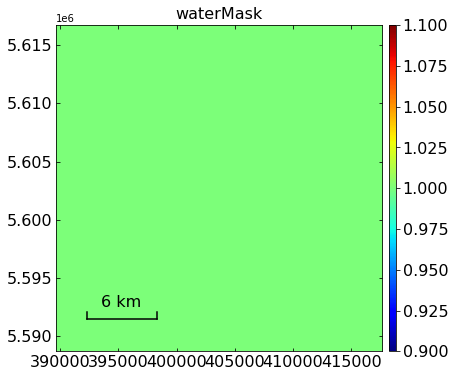

In [8]:
!generate_mask.py ./inputs/geometryGeo.h5 waterMask -m 0.5 -o waterMask.h5
view.main('waterMask.h5 --noverbose'.split())

## modify_network

This step has the largest effect on the overall quality of the analysis so **take your time here and remove garbage data !**
Remember the wise words:
> Garbage in, Garbage out.

In [9]:
!spatial_average.py inputs/ifgramStack.h5 -d coherence


*************** Spatial Average ******************
calculating spatial mean of coherence in file inputs/ifgramStack.h5 ...
[==================================================] 255/255    2s /     0s 
write average value in space into text file: coherenceSpatialAvg.txt


In [10]:
m = pd.read_csv('coherenceSpatialAvg.txt',skiprows=5,header=None,sep='\t',
                names=['DATE12','Mean','Btemp/days','Bperp/m','Num'])

m['date1'],m['date2'] = zip(*m['DATE12'].str.split('_'))
m['date1'] = pd.to_datetime(m['date1'])
m['date2'] = pd.to_datetime(m['date2'])

In [11]:
dates = sorted(list(set(list(m.date1) + list(m.date1))))

matrix = pd.DataFrame(index=dates,columns=dates)
for i,row in m.iterrows():
    if row['Btemp/days'] <= 40:
        matrix.loc[row['date1'],row['date2']] = row['Mean']
        matrix.loc[row['date2'],row['date1']] = row['Mean']
    
avg_coh = pd.DataFrame({'date':matrix.index,'coherence':matrix.mean(axis=1)}).reset_index(drop=True)

In [12]:
smooth_coh = avg_coh.copy()
smooth_coh.index = pd.DatetimeIndex(smooth_coh.date)
smooth_coh = smooth_coh.sort_index()
smooth_coh = smooth_coh.rolling(datetime.timedelta(days=90),center=True,min_periods=1).mean()
smooth_coh = smooth_coh.reset_index()

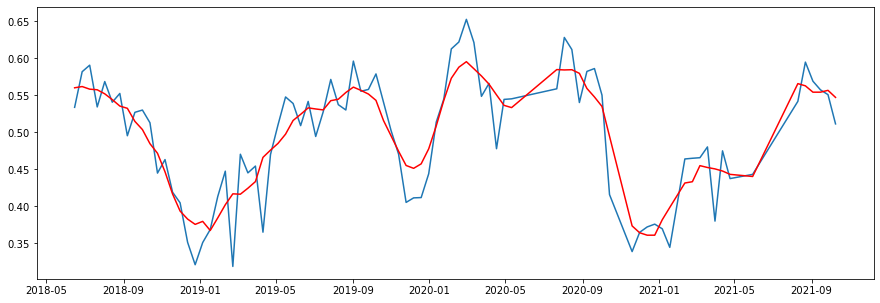

In [13]:
f = plt.figure(figsize=(15,5))

plt.plot(avg_coh.date,avg_coh.coherence)
plt.plot(smooth_coh.date,smooth_coh.coherence,color='red')

Based on this graph, there is a clear seasonal trend in the correlation data. I've found that performing the SBAS inversion on each year separately (breaking the analysis at the low points) produces the best results.

In [14]:
!cp ../hyp3_insar/hyp3.cfg ./hyp3.cfg
!smallbaselineApp.py ./hyp3.cfg --dostep modify_network

MintPy release version v1.3.0-128, release date 2021-09-27
--RUN-at-2021-10-25 16:14:33.763567--
Current directory: /home/fw/data/desc_lower
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: hyp3
Go to work directory: /home/fw/data/desc_lower
copy default template file /home/fw/tools/MintPy/mintpy/defaults/smallbaselineApp.cfg to work directory
read custom template file: /home/fw/data/desc_lower/hyp3.cfg
update default template based on input custom template
    mintpy.compute.maxMemory: auto --> 120
    mintpy.compute.cluster: auto --> local
    mintpy.load.processor: auto --> hyp3
    mintpy.load.unwFile: auto --> /mnt/i/hyp3_downlo

read options from template file: hyp3.cfg
read temporal/spatial baseline info from file: inputs/ifgramStack.h5
['coherenceSpatialAvg.txt'] exists and is newer than ['inputs/ifgramStack.h5', 'waterMask.h5'] --> skip.
coherenceSpatialAvg.txt already exists, read it directly
number of acquisitions: 87
number of interferograms: 255
shift all perp baseline by 36.34815216064453 to zero mean for plotting
--------------------------------------------------
number of interferograms marked as drop: 212
number of interferograms marked as keep: 43
number of acquisitions marked as drop: 68
['20180615', '20180627', '20180709', '20180721', '20180802', '20180814', '20180826', '20180907', '20180919', '20181001', '20181013', '20181025', '20181106', '20181118', '20181130', '20181212', '20181224', '20190105', '20190117', '20190129', '20190210', '20190222', '20190306', '20190318', '20190330', '20190411', '20190423', '20190505', '20190517', '20190529', '20190610', '20190622', '20190704', '20190716', '2019072

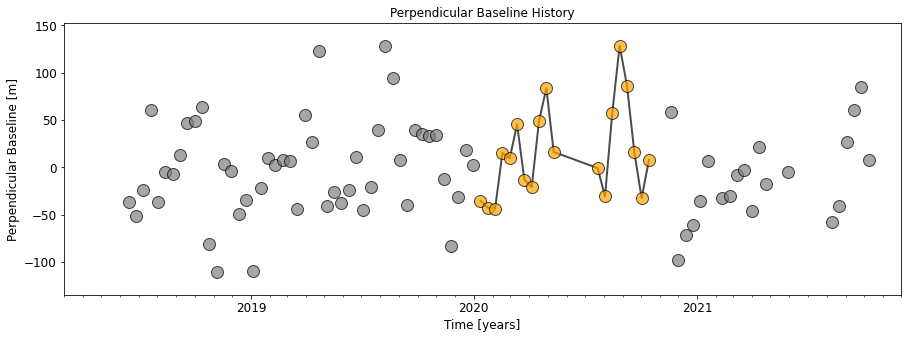

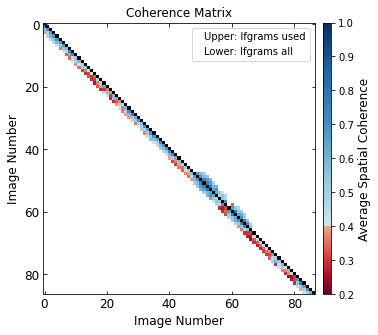

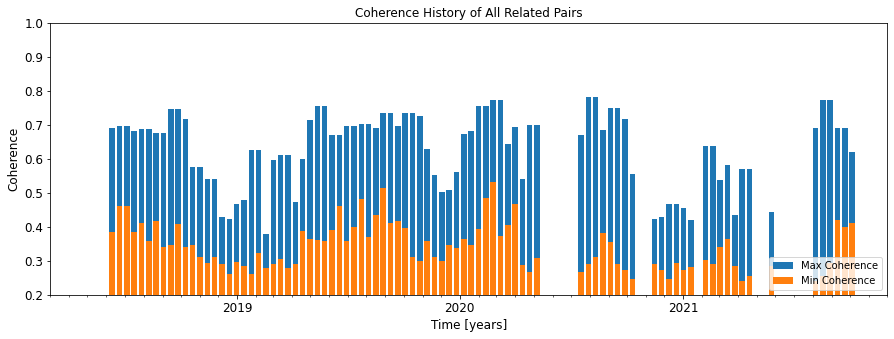

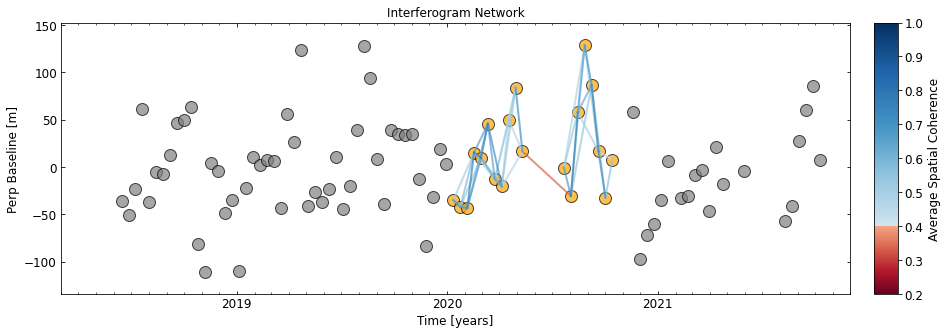

In [15]:
plot_network.main('inputs/ifgramStack.h5 -t hyp3.cfg --show-kept --figsize 15 5'.split())

view.py inputs/ifgramStack.h5 --noverbose --ref-yx 261 174 -n 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200


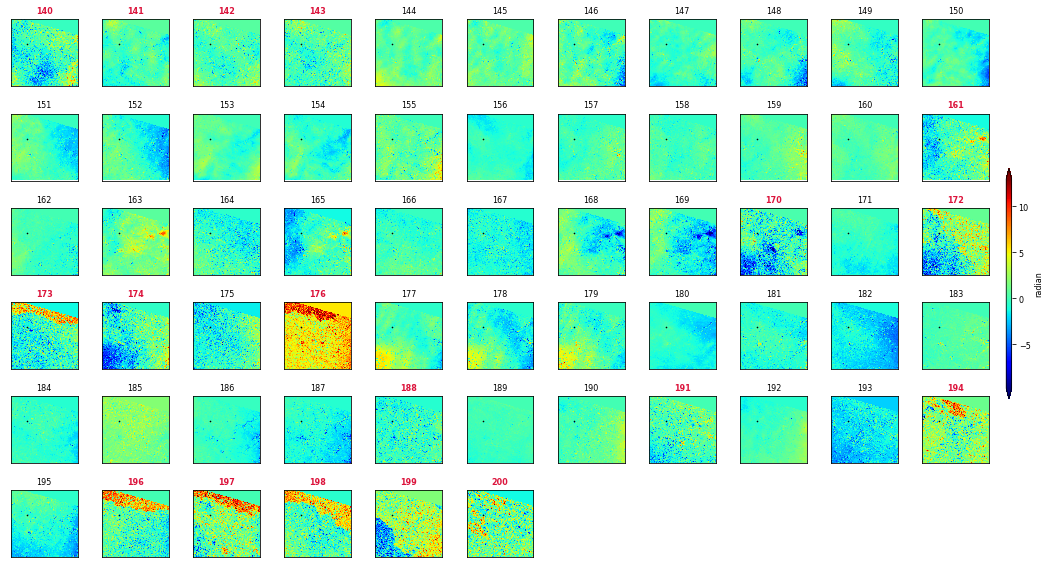

In [32]:
# view.main(f'inputs/ifgramStack.h5 --noverbose --ref-yx 234 184'.split())

l = [str(x) for x in range(140,201)]
# l = [str(x) for x in range(250,330)]
view.main(f'inputs/ifgramStack.h5 --noverbose --ref-yx 261 174 -n {" ".join(l)}'.split())

## reference_point

view.py inputs/geometryGeo.h5 height --noverbose


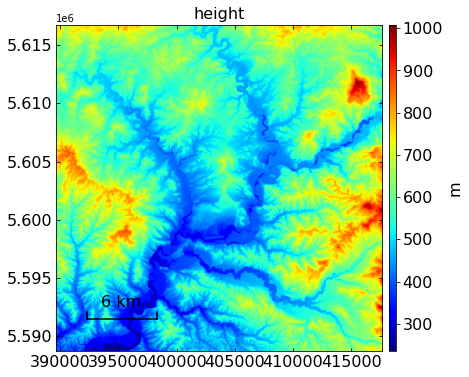

In [33]:
view.main('inputs/geometryGeo.h5 height --noverbose'.split())

In [20]:
!reference_point.py inputs/ifgramStack.h5 --reset
!cp ~/data/hyp3_insar/hyp3.cfg ./hyp3.cfg
!smallbaselineApp.py ./hyp3.cfg --dostep reference_point

remove REF_Y/X and/or REF_LAT/LON from file: inputs/ifgramStack.h5
All updated (removed) attributes already exists (do not exists) and have the same value, skip update.
Done.
MintPy release version v1.3.0-128, release date 2021-09-27
--RUN-at-2021-10-25 16:17:09.704664--
Current directory: /home/fw/data/desc_lower
Run routine processing with smallbaselineApp.py on steps: ['reference_point']
Remaining steps: ['quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: hyp3
Go to work directory: /home/fw/data/desc_lower
read custom template file: /home/fw/data/desc_lower/hyp3.cfg
update default template based on input custom template
    mintpy.load.unwFile: /mnt/i/hyp3_downloads/asc_upper/\*/\*unw_phase_clip.tif --> /mnt/i/hyp3_downloads/asc_upper/*/*unw_ph

view.py avgSpatialCoh.h5 --noverbose --figsize 8 8


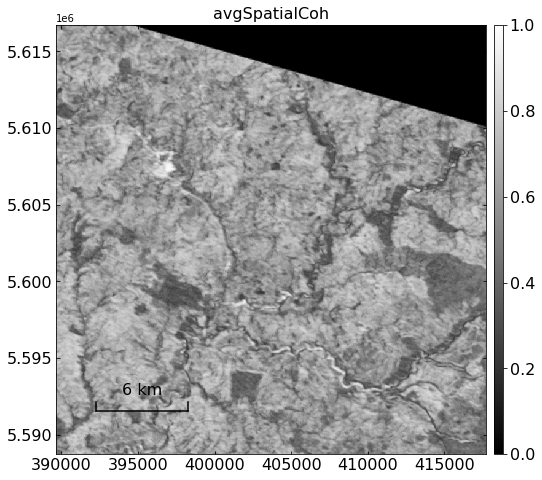

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
view.main('avgSpatialCoh.h5 --noverbose --figsize 8 8'.split())

## double_difference

In [24]:
desired_width = 3000
pixel_size = 40

x = 750
n_pixels = np.floor((desired_width / 40) /2)
width = ((n_pixels*2)+1)*400
print(f'N pixels: {n_pixels}\nActual width: {width}')

N pixels: 37.0
Actual width: 30000.0


slice(35, 40, None) slice(35, 40, None)


Text(0.5, 1.0, 'Width: 3000m')

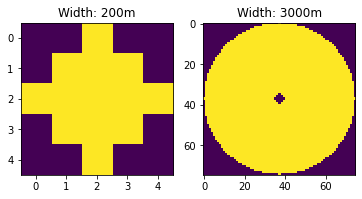

In [25]:
from skimage import morphology
filter_par = [2,37]

local_kernel = morphology.disk(filter_par[0], np.float32)
regional_kernel = morphology.disk(filter_par[1], np.float32)

center = slice(filter_par[1]-filter_par[0],filter_par[1]+filter_par[0]+1)
print(center,center)
regional_kernel[center,center] =  regional_kernel[center,center] - local_kernel

local_kernel = local_kernel / local_kernel.flatten().sum()
# local_filt = ndimage.convolve(data, local_kernel)

regional_kernel = regional_kernel / regional_kernel.flatten().sum()
# regional_filt = ndimage.convolve(data, regional_kernel)

f, (ax1,ax2) = plt.subplots(1,2)
img1 = ax1.imshow(local_kernel,interpolation='none')
ax1.set_title(f'Width: {local_kernel.shape[0]*40}m')
img2 = ax2.imshow(regional_kernel,interpolation='none')
ax2.set_title(f'Width: {regional_kernel.shape[0]*40}m')

In [28]:
params = [0,25]
outname = f'inputs/ifgramStack_{params[0]}_{params[1]}.h5'
!spatial_filter.py inputs/ifgramStack.h5 unwrapPhase -o {outname} -f double_difference -p {params[0]} {params[1]}

filtering ifgramStack file: inputs/ifgramStack.h5 using double_difference filter with local/regional kernel sizes of 0/25
filtering unwrapPhase from ifgramStack.h5  255/255 ...
create HDF5 file: inputs/ifgramStack_0_25.h5 with w mode
create dataset /coherence   of float32    in size of (255, 700, 700)      with compression=None
create dataset /unwrapPhase of float32    in size of (255, 700, 700)      with compression=None
create dataset /bperp       of float32    in size of (255,)     with compression=None
create dataset /date        of |S8        in size of (255, 2)   with compression=None
create dataset /dropIfgram  of bool       in size of (255,)     with compression=None
finished writing to inputs/ifgramStack_0_25.h5
Done.


By looking at the interferograms post-filtering, you can see that a lot of spatially-correlated atmospheric noise is removed.

view.py inputs/ifgramStack_2_37.h5 --noverbose --ref-yx 261 174 -n 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200


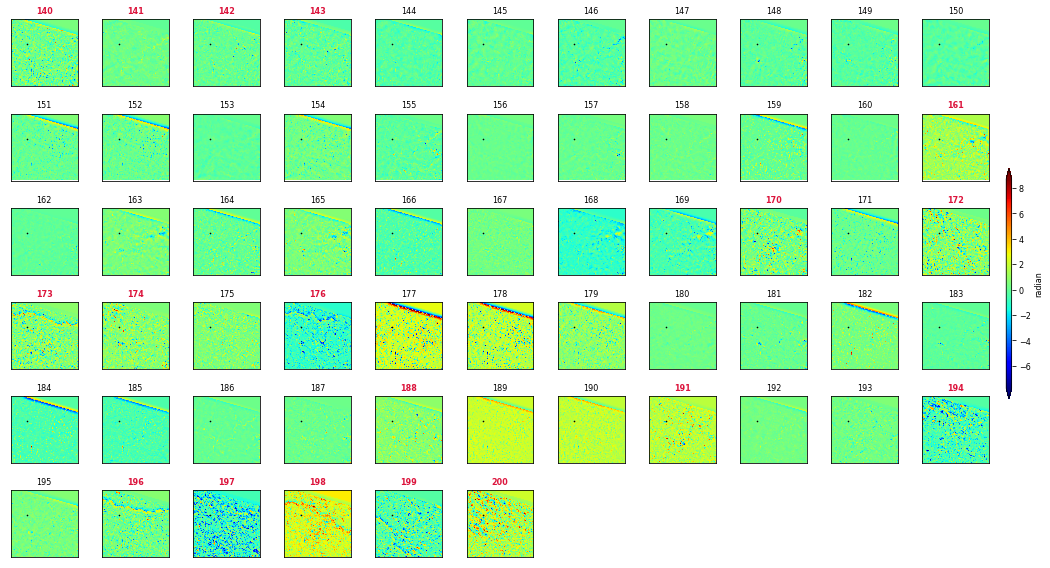

In [34]:
view.main(f'inputs/ifgramStack_2_37.h5 --noverbose --ref-yx 261 174 -n {" ".join(l)}'.split())

## invert_network
This can take a while so write it to a log if you need to.

In [49]:
# !ifgram_inversion.py inputs/ifgramStack.h5 -t ./hyp3.cfg |& tee -i invert.log ; python ../JPL_internship/emailme.py
!cp ../hyp3_insar/hyp3.cfg ./hyp3.cfg
!ifgram_inversion.py inputs/ifgramStack_2_37.h5 -t ./hyp3.cfg

use dataset "unwrapPhase" by default
save the original settings of ['OMP_NUM_THREADS', 'OPENBLAS_NUM_THREADS', 'MKL_NUM_THREADS', 'NUMEXPR_NUM_THREADS', 'VECLIB_MAXIMUM_THREADS']
set OMP_NUM_THREADS = 1
set OPENBLAS_NUM_THREADS = 1
set MKL_NUM_THREADS = 1
set NUMEXPR_NUM_THREADS = 1
set VECLIB_MAXIMUM_THREADS = 1
reference pixel in y/x: (234, 184) from dataset: unwrapPhase
-------------------------------------------------------------------------------
least-squares solution with L2 min-norm on: deformation velocity
minimum redundancy: 1.0
weight function: var
calculate STD: False 
mask: no
-------------------------------------------------------------------------------
number of interferograms: 43
number of acquisitions  : 19
number of lines   : 700
number of columns : 700
--------------------------------------------------
create HDF5 file: timeseries.h5 with w mode
create dataset  : date       of |S8                       in size of (19,)                with compression = None
create d

## Check temporal ramp

reading timeseries data from file: timeseries.h5 ...
(19, 700, 700)
slope: 0.0014 cm
r2:0.61


Text(0, 0.5, 'Avg Timeseries Value')

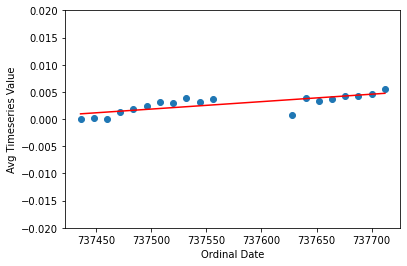

In [50]:
ts = timeseries(file='timeseries.h5')

data = ts.read()
# data[:,~coh_mask] = np.nan
dates = pd.to_datetime(ts.get_date_list())
means = np.nanmean(data,axis=(1, 2))

print(data.shape)
# datetimes = np.array([datetime.strptime(x,'%Y%m%d').toordinal() for x in dates])

datetimes = np.array([int(x.toordinal()) for x in dates])
slope, intercept, r, p, se = linregress(datetimes,means)
fit = slope*datetimes+intercept
print(f'slope: {round(slope*100,4)} cm\nr2:{round(r**2,2)}')

plt.scatter(datetimes,means)
plt.plot(datetimes,fit,color='red')
plt.ylim(-0.02,0.02)
plt.xlabel('Ordinal Date')
plt.ylabel('Avg Timeseries Value')

## velocity

In [77]:
outname = 'velocity.h5'
!timeseries2velocity.py timeseries.h5 -o {outname} --bootstrap --bc 100

bootstrapping is turned ON.
open timeseries file: timeseries.h5
--------------------------------------------------
dates from input file: 23
['20200131', '20200212', '20200224', '20200307', '20200319', '20200331', '20200412', '20200424', '20200506', '20200518', '20200530', '20200611', '20200623', '20200705', '20200717', '20200729', '20200810', '20200822', '20200903', '20200915', '20200927', '20201009', '20201021']
--------------------------------------------------
using all dates to calculate the velocity
--------------------------------------------------
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    step       : []
    exp        : {}
    log        : {}
add/update the following configuration metadata:
['startDate', 'endDate', 'excludeDate', 'bootstrap', 'bootstrapCount']
--------------------------------------------------
create HDF5 file: velocity.h5 with w mode
create dataset  : velocity    of <class 'numpy.float32'>

view.py velocity.h5 --noverbose -m no --vlim -10 10


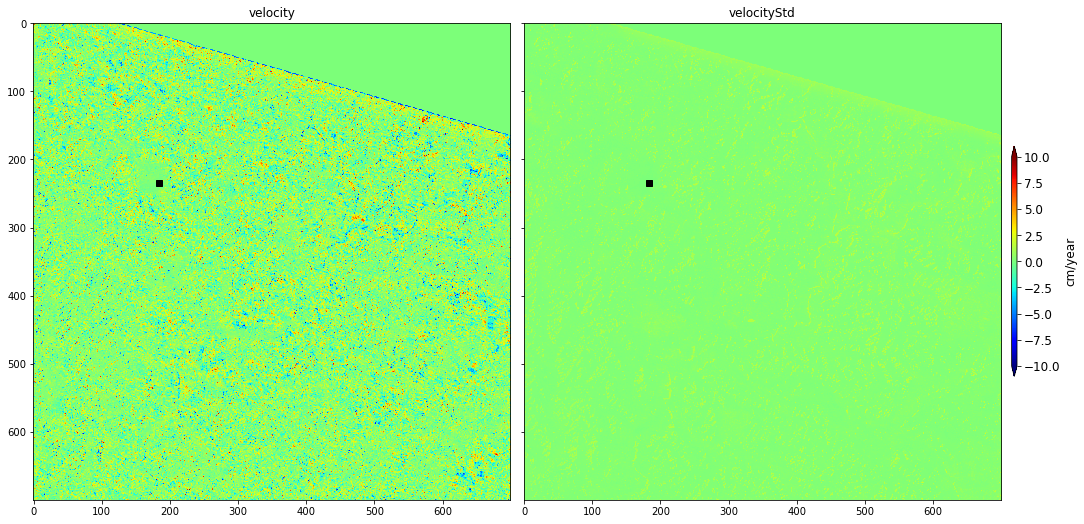

In [63]:
view.main(f'{outname} --noverbose -m no --vlim -10 10'.split())

In [68]:
# view.main('temporalCoherence.h5 --noverbose --colormap RdBu_truncate --cm-vlist 0.0 0.4 1.0'.split())

## store result files

In [53]:
name = 'dd_2_37_2020'
name_path = f'./{name}/'
!mkdir {name}
!mv temporalCoherence.h5 timeseries.h5 timeseriesResidual.h5 velocity.h5 numInvIfgram.h5 {name_path}
# !save_gdal.py ./{name}/velocity.h5 -o ../hyp3_insar/results/{name}_desc.tif

## Masking

### RMSE

In [71]:
from pathlib import Path
# !timeseries_rms.py timeseriesResidual.h5 -r no

data, atr = readfile.read('timeseriesResidual.h5')
rmse = np.sqrt(np.square(data).sum(axis=0) / data.shape[0])
out_file = Path(atr['FILE_PATH']).parent / 'rmse.h5'
atr['FILE_PATH'] = str(out_file)
atr['FILE_TYPE'] = 'rmse'
writefile.write({'rmse':rmse},out_file,atr)

create HDF5 file: /home/fw/data/asc_upper/rmse.h5 with w mode
create dataset /rmse of float32    in size of (700, 700)           with compression=None
finished writing to /home/fw/data/asc_upper/rmse.h5


PosixPath('/home/fw/data/asc_upper/rmse.h5')

view.py rmse.h5 --vlim -6 6 -m no --noverbose


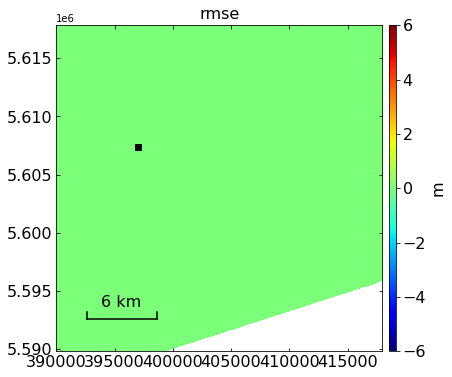

In [72]:
view.main('rmse.h5 --vlim -6 6 -m no --noverbose'.split())

Mean of velocityStd: 0.003100000089034438
delete exsited file: velocityMask.h5
create HDF5 file: velocityMask.h5 with w mode
create dataset /velocity    of float32    in size of (500, 500)           with compression=None
create dataset /velocityStd of float32    in size of (500, 500)           with compression=None
finished writing to velocityMask.h5
view.py velocityMask.h5 --noverbose --vlim -5 5


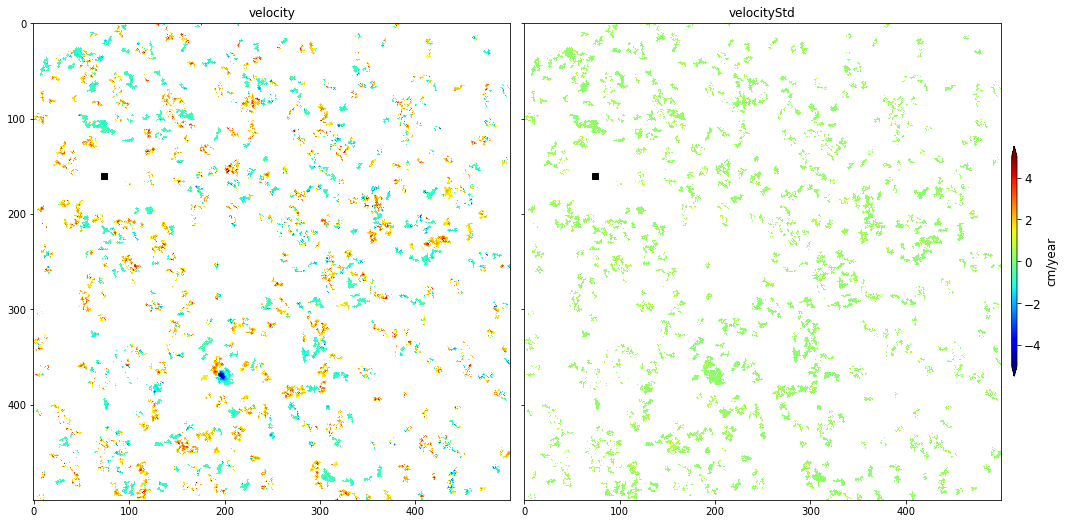

In [756]:
data, atr = readfile.read('velocity.h5',datasetName='velocity')
data_std, atr = readfile.read('velocity.h5',datasetName='velocityStd')
coh, _ = readfile.read('temporalCoherence.h5')

print(f'Mean of velocityStd: {data_std.mean().round(4)}')
mean, std = data.mean(),data.std()

mask_coh = coh > 0.7
mask_std = np.abs(data) > (data_std * 2)
mask_vel = (data < (mean+-std)) | (data > (mean+std))

# mask = mask_vel & mask_std
mask = mask_vel

remove_small_objects(mask,min_size=20,in_place=True)

data[~mask] = np.nan
data_std[~mask] = np.nan

# f = plt.figure(figsize=(10,10))
# plt.imshow(mask_vel,interpolation='nearest')

writefile.write({'velocity':data,'velocityStd':data_std}, 'velocityMask.h5', ref_file='velocity.h5')
view.main('velocityMask.h5 --noverbose --vlim -5 5'.split())

## View Results

### Velocity with VelocityStd

view.py velocity.h5 --noverbose --vlim -3 3


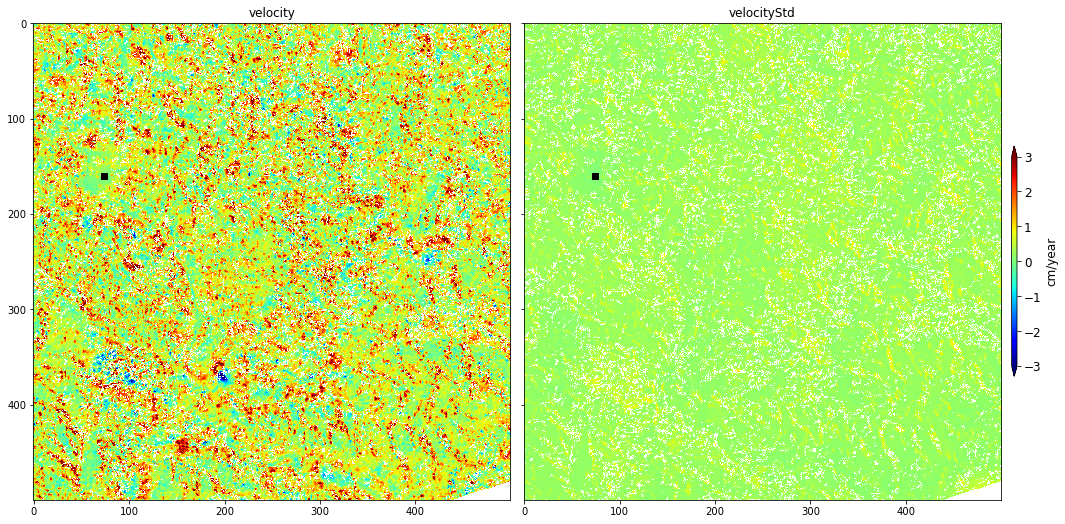

In [634]:
%matplotlib inline
import matplotlib.pyplot as plt
# view.main('velocity.h5 --noverbose --vlim -5 5'.split())
view.main('velocity.h5 --noverbose --vlim -3 3'.split())

### Dem with velocity overlay

view.py ./velocity.h5 velocity --dem ./inputs/geometryGeo.h5 --shade-exag 0.05 --figsize 12 12 --notitle --notick --noaxis --noverbose


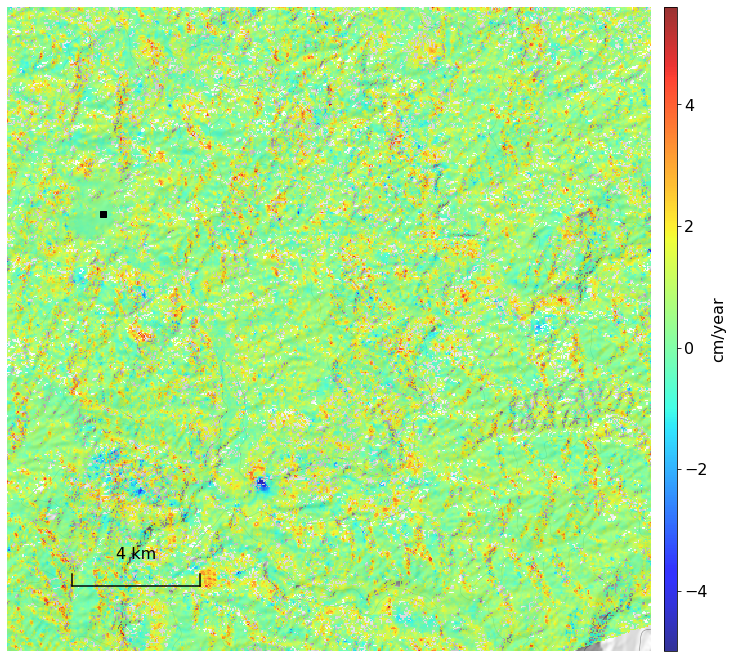

In [635]:
view.main('./velocity.h5 velocity --dem ./inputs/geometryGeo.h5 --shade-exag 0.05 --figsize 12 12 --notitle --notick --noaxis --noverbose'.split())

### Temporal Coherence

view.py temporalCoherence.h5 --noverbose --colormap RdBu_truncate --cm-vlist 0.0 0.7 1.0


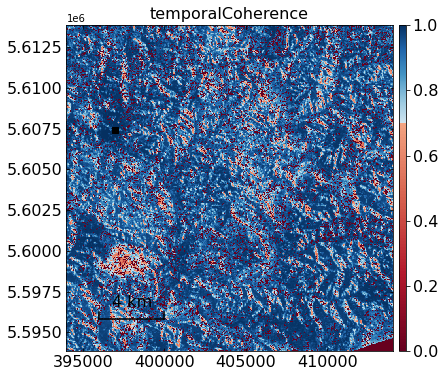

In [637]:
view.main('temporalCoherence.h5 --noverbose --colormap RdBu_truncate --cm-vlist 0.0 0.7 1.0'.split())

input temporalCoherence file: temporalCoherence.h5
read temporalCoherence.h5
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value < 0.7
create HDF5 file: tcohMask.h5 with w mode
create dataset /mask of bool       in size of (500, 500)           with compression=None
finished writing to tcohMask.h5
time used: 00 mins 0.1 secs.
view.py velocity.h5 -m tcohMask.h5 --noverbose --vlim -5 5


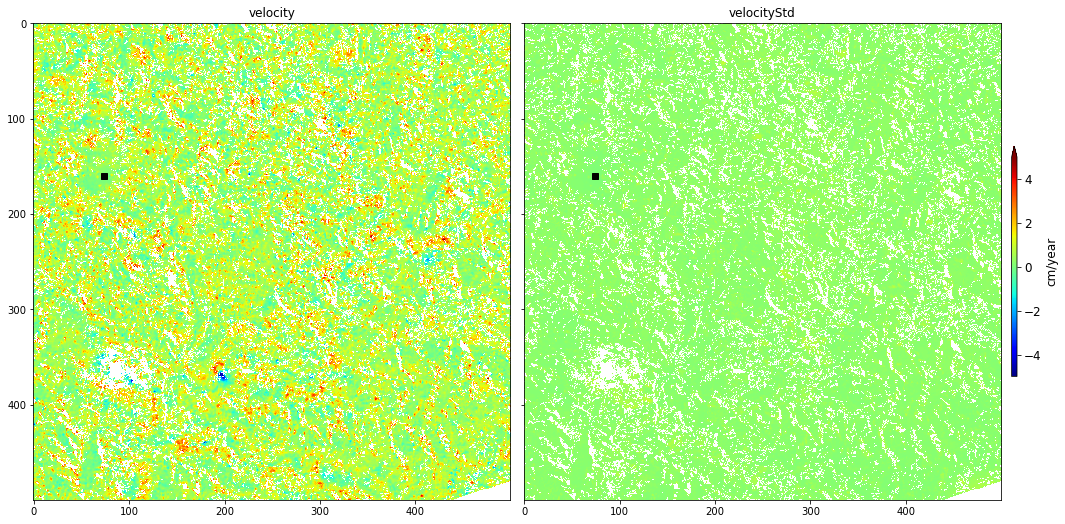

In [638]:
!generate_mask.py temporalCoherence.h5 --min 0.7 -o tcohMask.h5
# !mask.py velocity.h5 -m tcohMask.h5 -o velocityMask.h5
view.main('velocity.h5 -m tcohMask.h5 --noverbose --vlim -5 5'.split())

### Timeseries Viewer

In [426]:
# visualization functions
def tsview(fname, yx=None, figsize_img=[5, 4], figsize_pts=[5, 2]):
    """Plot input file using tsview.py"""
    cmd = 'tsview.py {} --ms 4 --noverbose'.format(fname)
    if yx is not None:
        cmd += ' --yx {} {}'.format(yx[0], yx[1])
    obj = timeseriesViewer(cmd)
    obj.configure()
    obj.figsize_img = figsize_img
    obj.figsize_pts = figsize_pts
    obj.plot()
    return obj

tsview.py timeseries.h5 --ms 4 --noverbose
No lookup table info range/lat found in files.
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    step       : []
    exp        : {}
    log        : {}


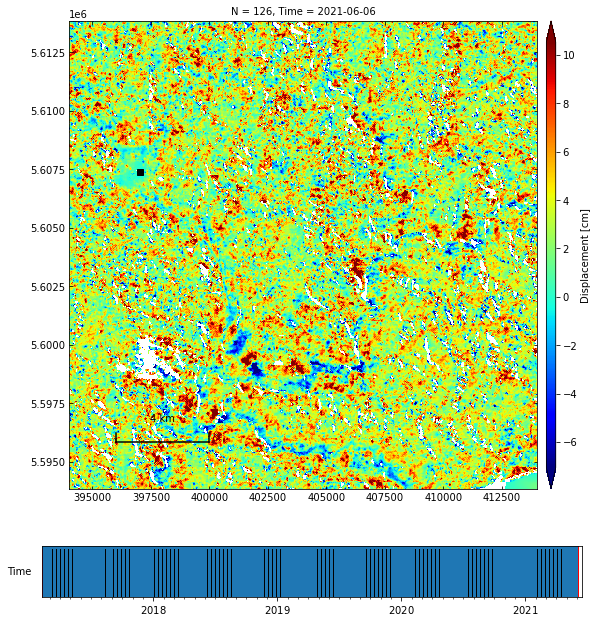

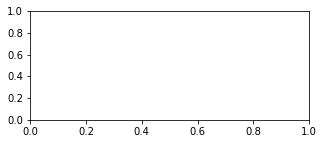

In [428]:
%matplotlib inline
import matplotlib.pyplot as plt
# ts_file = os.path.expanduser('~/data/SanFranSenDT42/mintpy/timeseries_ERA5_demErr.h5')
tsview('timeseries.h5', figsize_img=[10,10])

## Export to GDAL

In [189]:
!save_gdal.py ./dd_2_25_2020/velocity.h5 -o ../hyp3_insar/results/dd_2_25_2020.tif

read metadata from file: ./dd_2_25_2020/velocity.h5
read data     from file: ./dd_2_25_2020/velocity.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 500, 500
raster transform info: (394000.0, 40.0, 0, 5613840.0, 0, -40.0)
write data to raster band
set projection as: EPSG 32760
finished writing to /home/fw/data/hyp3_insar/results/dd_2_25_2020.tif


In [275]:
# mv ./run01/waterMask.h5 .
# cp ./pic/Haywrd_05502_01-S2.cfg ./run01/